First try and run alpha shapes in batch

In [1]:
import numpy as np
from scipy.spatial import Delaunay
import math

In [2]:
import os
import numpy as np
import pandas as pd
import time
import skimage.io as io
io.use_plugin('tifffile')
import glob
from skimage import morphology
import mahotas as mh
from skimage.filters import threshold_adaptive
from scipy.ndimage import distance_transform_edt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import regionprops

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

In [3]:
from descartes import PolygonPatch
from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize
from matplotlib.collections import PolyCollection, transforms
from skimage.measure import grid_points_in_poly

In [4]:
from matplotlib.path import Path

In [5]:
from matplotlib.patches import Polygon

In [6]:
#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [7]:
#[2] Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

shell_list=glob.glob(path+str('/Output/Shells/*Split_Shells.npy'))

In [8]:
[Hoechst_stack, GFP_stack] = load_ome(filelist[4])

In [9]:
#[1] Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/'

target='_Mask5.npy'

masklist=glob.glob(path+str('*')+target)

In [10]:
mask5 = np.load(masklist[1])

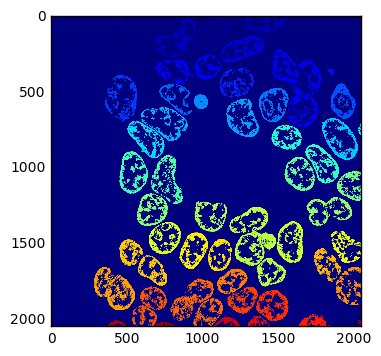

In [11]:
plt.imshow(mask5[8])

In [12]:
z=4
obj=6

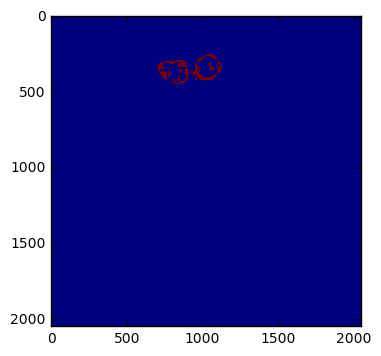

In [13]:
plt.imshow(mask5[z]==obj)

Functions

In [14]:
#[1]
def mask2points(binary_mask):
    
    points=np.transpose(np.nonzero(binary_mask))
    
    #print(len(points))

    #Return row, column coordinates converted to x, y
    return np.fliplr(points)

In [15]:
#[3]
def AlphaShape(points, triangles, alpha=0.25):
    
    edges = set()
    edge_points = []

    #print str(len(tri.vertices))+' triangles detected'
    
    #Not sure why, but this function must be embedded.
    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(points[ [i, j] ])
        #End of function

    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in triangles.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))

        if area>0:
            circum_r = a*b*c/(4.0*area)

            # Here's the radius filter.
            if circum_r < 1.0/alpha:
                add_edge(ia, ib)
                add_edge(ib, ic)
                add_edge(ic, ia)

    #print str(len(edge_points))+' edge points returned'    
    return edge_points

In [16]:
#[4] Convert points to boundary
# def edges2path(edge_points):
#     m = MultiLineString(edge_points)
#     triangles = list(polygonize(m))
#     polypath = (PolygonPatch(cascaded_union(triangles))).get_path()
#     return polypath

In [17]:
#[4] Convert points to boundary
def edges2path(edge_points):
    m = MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
    #Convert triangles to polygon object
    boundary = cascaded_union(triangles)
    ptch = PolygonPatch(boundary)
    
    #Convert polygon path to a path
    polypath = ptch.get_path()
    return polypath

In [18]:
#[5] Path to Mask
def path2mask(stack, polypath):

    #Check shape of stack
    shape=stack.shape

    #flip x and y to r and c
    vert = np.fliplr(polypath.vertices)

    #Generate binary mask
    return grid_points_in_poly(shape, vert)

In [19]:
def getMask(labeled_stack, z, obj, alpha=0.25):
             
    points=[]
    triangles=[]
    edge_points=[]
    polypath=[]
    mask=np.zeros_like(labeled_stack[z])
        
    #[1] Convert mask row, column coordinates to x, y
    points = mask2points(labeled_stack[z]==obj)

    #[2] Triangluate
    triangles = Delaunay(points)

    #[3] Alpha Shape
    edge_points = AlphaShape(points, triangles, alpha)

    #[4] Convert triangles to polygon
    polypath = edges2path(edge_points)

    #[5] get polygon
    mask = path2mask(labeled_stack[z], polypath)*obj
                              
    return mask     

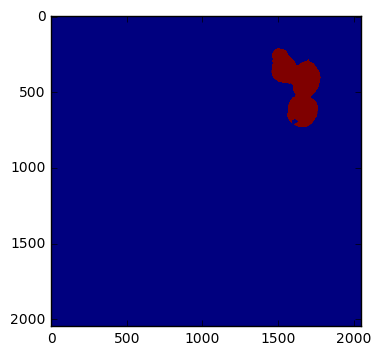

In [20]:
mask8 = getMask(mask5, z=4, obj=5, alpha=0.10)
plt.imshow(mask8)

Then try it on Puncta

In [21]:
#[1] Get targeted filelist
punc_path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/PunctaByShell/'

punc_target='_Puncta.npy'

punc_list=glob.glob(punc_path+str('*')+punc_target)
punc_list[1]

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/PunctaByShell\\Well02_HeLa_PHD2-IDR-PHD3_2_Puncta.npy'

In [22]:
##Load Puncta mask
puncta = np.load(punc_list[1])

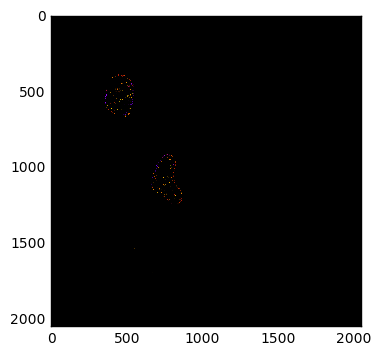

In [23]:
plt.imshow(puncta[16], cmap="gnuplot")

In [24]:
#Operate on a smaller ROI
# ROI_Hoechst = Hoechst_stack[z, 350:750, 250:650]
# ROI = GFP_stack[z, 350:750, 250:650]
ROI_puncta = puncta[:, 350:750, 250:650]

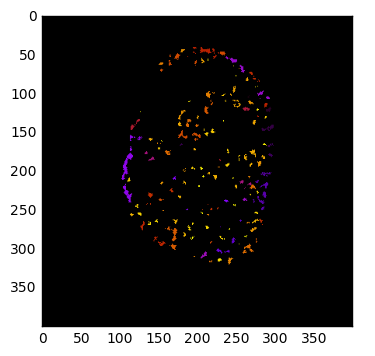

In [25]:
plt.imshow(ROI_puncta[16], cmap="gnuplot")

In [26]:
#relabel ROI_puncta
ROI_puncta, n_puncta = mh.labeled.relabel(ROI_puncta.astype(int), inplace=True)
n_puncta

392L

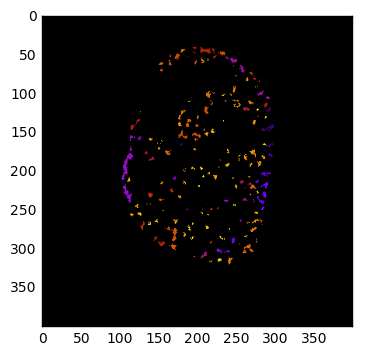

In [27]:
plt.imshow(ROI_puncta[16], cmap="gnuplot")

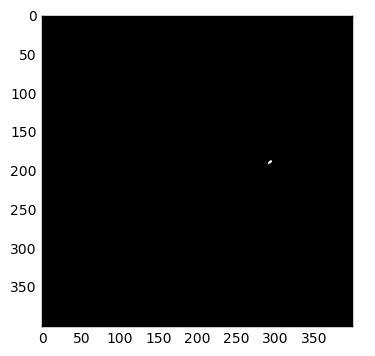

In [28]:
plt.imshow(ROI_puncta[3]==50, cmap="gray")

Then try on 3D objects

In [60]:
##Does it work in 3D?
#[1] Convert mask to points
points=np.transpose(np.nonzero(ROI_puncta==50))
#points #z, r, c
#Sort points to x, y, z columns
new_order = [2,1,0]
i = np.argsort(new_order)
points = points[:,i]

In [68]:
points

array([[293, 186,   0],
       [295, 186,   0],
       [292, 187,   0],
       [293, 187,   0],
       [294, 187,   0],
       [295, 187,   0],
       [296, 187,   0],
       [292, 188,   0],
       [293, 188,   0],
       [294, 188,   0],
       [295, 188,   0],
       [292, 189,   0],
       [293, 189,   0],
       [294, 189,   0],
       [298, 189,   0],
       [292, 190,   0],
       [293, 190,   0],
       [295, 190,   0],
       [297, 190,   0],
       [298, 190,   0],
       [299, 190,   0],
       [300, 190,   0],
       [297, 191,   0],
       [299, 191,   0],
       [300, 191,   0],
       [291, 186,   1],
       [292, 186,   1],
       [294, 186,   1],
       [292, 187,   1],
       [293, 187,   1],
       [294, 187,   1],
       [295, 187,   1],
       [291, 188,   1],
       [292, 188,   1],
       [293, 188,   1],
       [294, 188,   1],
       [292, 189,   1],
       [293, 189,   1],
       [294, 189,   1],
       [295, 189,   1],
       [297, 189,   1],
       [298, 189

In [71]:
##1st try Convexhull
from scipy.spatial import ConvexHull

hull = ConvexHull(points)
indices = hull.simplices
vertices = points[indices]

In [77]:
vertices

array([[[291, 185,   2],
        [293, 186,   0],
        [293, 182,   6]],

       [[295, 186,   0],
        [293, 186,   0],
        [293, 182,   6]],

       [[291, 185,   8],
        [291, 185,   2],
        [290, 189,   4]],

       [[292, 183,   8],
        [291, 185,   8],
        [292, 185,   9]],

       [[297, 191,   0],
        [292, 190,   0],
        [293, 192,   1]],

       [[291, 186,   1],
        [291, 185,   2],
        [293, 186,   0]],

       [[291, 186,   1],
        [291, 185,   2],
        [290, 189,   4]],

       [[293, 183,   8],
        [292, 183,   8],
        [292, 185,   9]],

       [[293, 183,   8],
        [294, 183,   7],
        [293, 182,   6]],

       [[293, 183,   8],
        [292, 183,   8],
        [293, 182,   6]],

       [[292, 183,   7],
        [291, 185,   2],
        [293, 182,   6]],

       [[292, 183,   7],
        [292, 183,   8],
        [293, 182,   6]],

       [[292, 187,   0],
        [291, 186,   1],
        [293, 186,   0]],


In [75]:
voxels = hull.volume
surf = hull.area

hull.

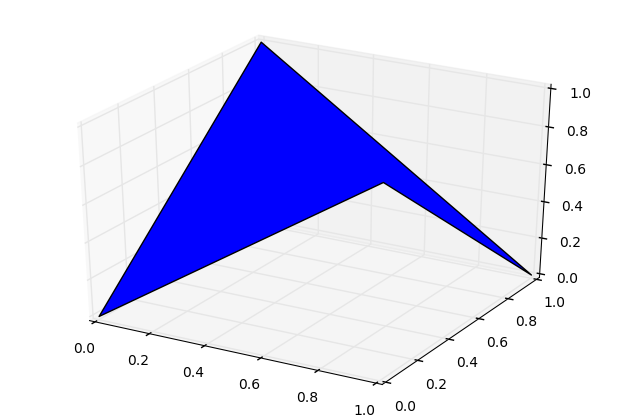

In [76]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [0,1,1,0]
y = [0,0,1,1]
z = [0,1,0,1]
verts = [zip(x, y,z)]
ax.add_collection3d(Poly3DCollection(verts))
plt.show()

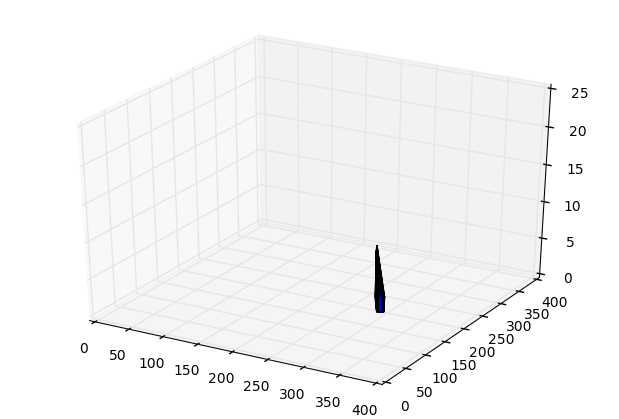

In [85]:
fig = plt.figure()
ax = Axes3D(fig)
ax.auto_scale_xyz([0,400],[0,400],[0,24])
ax.add_collection3d(Poly3DCollection(vertices))
plt.show()

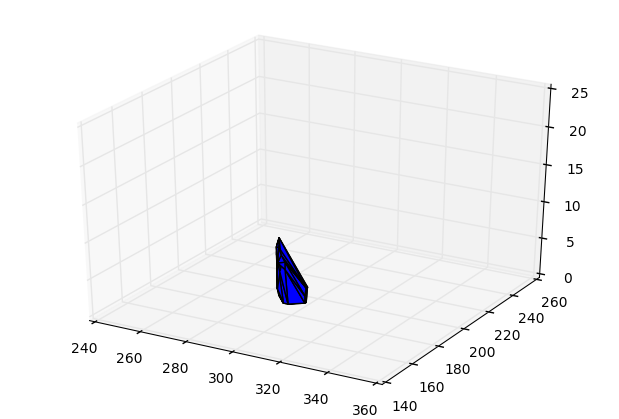

In [84]:
fig = plt.figure()
ax = Axes3D(fig)
ax.auto_scale_xyz([250,350],[150,250],[0,24])

# verts = [zip(x, y,z)]
ax.add_collection3d(Poly3DCollection(vertices))
plt.show()

In [69]:
#Much slower than 2D (13minutes for 506,144)
t0=time.time()
#Calculate tetrahedra
tetra = Delaunay(points)
t1=time.time()
print t1-t0

0.0139999389648


In [70]:
tetra.simplices

array([[ 22,  16,  15,  51],
       [ 26,   2,  25,   0],
       [ 53,  52,   0, 126],
       ..., 
       [157, 156, 144, 153],
       [157, 154, 143,  78],
       [157, 146, 143,  78]])

In [62]:
#How many points are there in the 3D mask?
len(points)

161

In [63]:
#Incredibly slow but successful method
tri3D=[]

for row in tetra.simplices:
    tri3D.append([row[0],row[1],row[2]])
    tri3D.append([row[0],row[1],row[3]])
    tri3D.append([row[0],row[2],row[3]])
    tri3D.append([row[1],row[2],row[3]])

tri3D = np.array(tri3D)

In [64]:
len(tri3D)

3436

In [65]:
tri3D

array([[ 22,  16,  15],
       [ 22,  16,  51],
       [ 22,  15,  51],
       ..., 
       [157, 146,  78],
       [157, 143,  78],
       [146, 143,  78]])

In [35]:
#Investgative function not required
def triprops(triangles):

    tps=[]
    
    #avoid loop
    for ia, ib, ic in triangles:
            pa = points[ia]
            pb = points[ib]
            pc = points[ic]

            # Absolute lengths of sides of triangle
            a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
            b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
            c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
            
            #provided no lengths = 0
            if (a >0 and b > 0 and c > 0):
            
                # Semiperimeter of triangle
                s = (a + b + c)/2.0

                # Area of triangle by Heron's formula
                squarea = s*(s-a)*(s-b)*(s-c)
                area= math.sqrt(squarea)

                #tps.append([a, b, c, s, squarea])
                tps.append([a, b, c, s, area]) 

    return pd.DataFrame(tps, columns=['a','b','c','s','area'])

In [36]:
triangle_properties = triprops(tri3D)

3D Alpha Shape approach must work on tetrahedra, not triangles, because if any face of the tetrahedra falls below the cutoff then the tetrahedron will have no volume, but some triangles may still pass the cutoff and remain.

In [37]:
#[3]
def AlphaShape2(points, triangles, alpha=0.25):
    
    edges = set()
    edge_points = []

    #print str(len(tri.vertices))+' triangles detected'
    
    #Not sure why, but this function must be embedded.
    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(points[ [i, j] ])
        #End of function

    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in triangles:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        
        #provided no lengths = 0
        if (a >0 and b > 0 and c > 0):

            # Semiperimeter of triangle
            s = (a + b + c)/2.0

            # Area of triangle by Heron's formula
            area = math.sqrt(s*(s-a)*(s-b)*(s-c))

            if area>0:
                circum_r = a*b*c/(4.0*area)

                # Here's the radius filter.
                if circum_r < 1.0/alpha:
                    add_edge(ia, ib)
                    add_edge(ib, ic)
                    add_edge(ic, ia)

    #print str(len(edge_points))+' edge points returned'    
    return edge_points

In [38]:
#Try alpha shape on 3D triangles
t0=time.time()
edge_points = AlphaShape2(points, tri3D, alpha=0.25)
t1=time.time()
print t1-t0

0.0350000858307


Can you convert the edges to a 3D polygon?

In [69]:
polypath = edges2path(edge_points)

In [71]:
puncta_mask = path2mask(ROI_puncta, polypath)

In [72]:
puncta_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

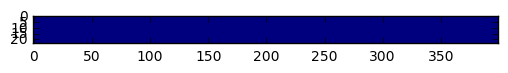

In [73]:
plt.imshow(puncta_mask)

This is not the way!!

In [74]:
#What do the 'edge points' look like?
edge_points
#They look good/ 3D

[array([[  0, 297, 191],
        [  2, 293, 192]], dtype=int64), array([[  2, 293, 192],
        [  1, 293, 192]], dtype=int64), array([[  1, 293, 192],
        [  0, 297, 191]], dtype=int64), array([[  2, 300, 192],
        [  2, 293, 192]], dtype=int64), array([[  1, 293, 192],
        [  2, 300, 192]], dtype=int64), array([[  1, 299, 191],
        [  2, 300, 192]], dtype=int64), array([[  2, 300, 192],
        [  0, 300, 191]], dtype=int64), array([[  0, 300, 191],
        [  1, 299, 191]], dtype=int64), array([[  1, 299, 191],
        [  2, 300, 191]], dtype=int64), array([[  2, 300, 191],
        [  0, 300, 191]], dtype=int64), array([[  3, 295, 187],
        [  0, 296, 187]], dtype=int64), array([[  0, 296, 187],
        [  0, 295, 186]], dtype=int64), array([[  0, 295, 186],
        [  3, 295, 187]], dtype=int64), array([[  5, 295, 184],
        [  0, 296, 187]], dtype=int64), array([[  0, 295, 186],
        [  5, 295, 184]], dtype=int64), array([[  1, 299, 189],
        [  0, 2

In [40]:
#[4] Convert points to 3D boundary - THIS NEED ATTENTION
# def edges2path(edge_points):
m = MultiLineString(edge_points)    
poly3d = list(polygonize(m))
    
#     #Convert triangles to polygon object
#     boundary = cascaded_union(triangles)
#     ptch = PolygonPatch(boundary)
    
#     #Convert polygon path to a path
#     polypath = ptch.get_path()
#     return polypath

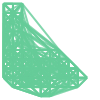

In [41]:
m

In [51]:
edge_points

[array([[  0, 297, 191],
        [  2, 293, 192]], dtype=int64), array([[  2, 293, 192],
        [  1, 293, 192]], dtype=int64), array([[  1, 293, 192],
        [  0, 297, 191]], dtype=int64), array([[  2, 300, 192],
        [  2, 293, 192]], dtype=int64), array([[  1, 293, 192],
        [  2, 300, 192]], dtype=int64), array([[  1, 299, 191],
        [  2, 300, 192]], dtype=int64), array([[  2, 300, 192],
        [  0, 300, 191]], dtype=int64), array([[  0, 300, 191],
        [  1, 299, 191]], dtype=int64), array([[  1, 299, 191],
        [  2, 300, 191]], dtype=int64), array([[  2, 300, 191],
        [  0, 300, 191]], dtype=int64), array([[  3, 295, 187],
        [  0, 296, 187]], dtype=int64), array([[  0, 296, 187],
        [  0, 295, 186]], dtype=int64), array([[  0, 295, 186],
        [  3, 295, 187]], dtype=int64), array([[  5, 295, 184],
        [  0, 296, 187]], dtype=int64), array([[  0, 295, 186],
        [  5, 295, 184]], dtype=int64), array([[  1, 299, 189],
        [  0, 2

In [48]:
#Need to reorganise edge points to x, y, z format

#Sort points to z, x, y columns
new_order = [1,2,0]
i = np.argsort(new_order)
edge_points = edge_points[:,i]


TypeError: list indices must be integers, not tuple

In [56]:
len(m.geoms)

936

In [59]:
m.geoms[0:10].coords

NotImplementedError: Multi-part geometries do not provide a coordinate sequence

AttributeError: 'list' object has no attribute 'get_label'

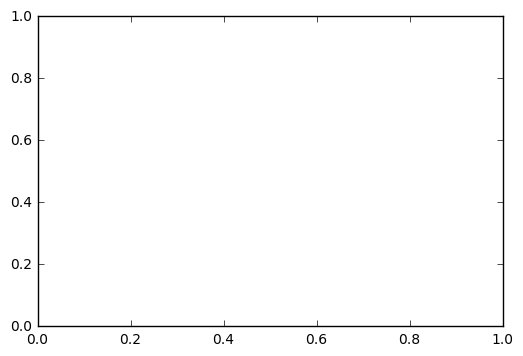

In [47]:
plt.figure()
# plt.title('Alpha=2.0 Delaunay triangulation')
plt.gca().add_collection(poly3d)

AttributeError: 'module' object has no attribute 'add_collection'

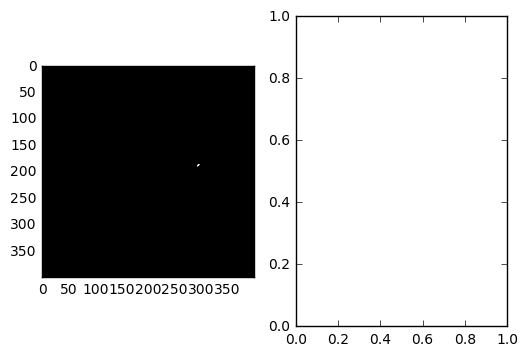

In [45]:
##Can I compare m and the original mask
plt.subplot(1,2,1), plt.imshow(ROI_puncta[3]==50, cmap="gray")
plt.subplot(1,2,2), plt.add_collection(m)

In [ ]:
#[5] Path to Mask 3D
def path2mask(stack, polypath):

    #Check shape of stack
    shape=stack.shape

    #flip x and y to r and c
    vert = np.fliplr(polypath.vertices)

    #Generate binary mask
    return grid_points_in_poly(shape, vert)